In [128]:
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)
!nvidia-smi

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, LayerNormalization
from tensorflow.nn import relu

from sionna.phy.mimo import StreamManagement

#from sionna.phy.ofdm import CSIGridMapper
from sionna.phy.ofdm import ResourceGrid, ResourceGridMapper, ResourceGridDemapper, LSChannelEstimator, LMMSEEqualizer
from sionna.phy.ofdm import OFDMModulator, OFDMDemodulator, RemoveNulledSubcarriers, ZFEqualizer

from sionna.phy.channel.tr38901 import Antenna, AntennaArray, CDL, UMi, UMa, RMa
from sionna.phy.channel import gen_single_sector_topology as gen_topology
from sionna.phy.channel import subcarrier_frequencies, cir_to_ofdm_channel, cir_to_time_channel
from sionna.phy.channel import ApplyOFDMChannel, ApplyTimeChannel, OFDMChannel

from sionna.phy.fec.ldpc.encoding import LDPC5GEncoder
from sionna.phy.fec.ldpc.decoding import LDPC5GDecoder

from sionna.phy.mapping import Mapper, Demapper, BinarySource, QAMSource

from sionna.phy.utils import ebnodb2no, sim_ber
from sionna.phy.utils.metrics import compute_ber
# from sionna.ofdm import CSIGridMapper

Number of GPUs available : 0
Tue Aug  5 17:23:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    Off |   00000000:AC:00.0 Off |                  Off |
| 30%   48C    P8             33W /  300W |      34MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------

Tx_Power: 0.1772876696043162
Noise: -120.22878745280337


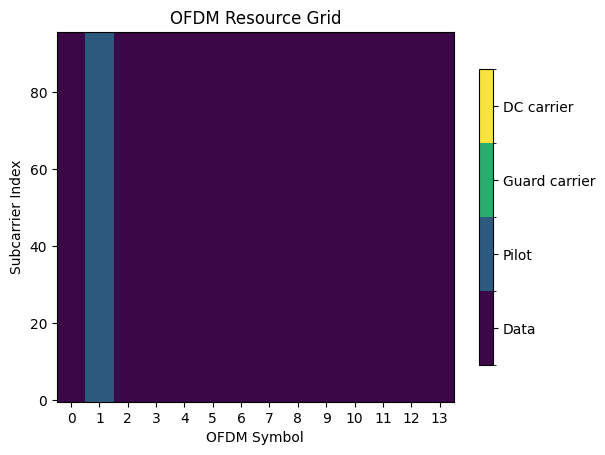

In [129]:
scenario = "umi"
carrier_frequency = 5.3e9
direction = "uplink"
num_ut = 1
batch_size = 5000

num_RB   = 8
num_symbols = 14
num_SC = 96
fft_size = 12*num_RB
subcarrier_spacing = 30e3

## Tx Power
TxPower_dBm     = 20 # in dBm
TxPower         = 10**((TxPower_dBm-30)/10)
TxPower_SC      = TxPower/(num_SC)
TxPower_SC_dBm  = 10*np.log10(TxPower_SC*1000)

# Noise Power
noise_psd       = -174                                  # in dBm/Hz
noise_figure    = 9                                     # in dB
noise_SC_Watt   = 10**((noise_psd + noise_figure - 30)/10)*subcarrier_spacing
noise_SC_dBm    = 10*np.log10(noise_SC_Watt*1000)

print("Tx_Power:",TxPower_SC_dBm)
print("Noise:",noise_SC_dBm)

tf.random.set_seed(1)
# Define the UT antenna array
ut_array = Antenna(polarization="single",
                   polarization_type="V",
                   antenna_pattern="omni",
                   carrier_frequency=carrier_frequency)

# Define the BS antenna array
bs_array = AntennaArray(num_rows=1,
                             num_cols=1, # We want to transmitter to be equiped with the 16 rx antennas
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             polarization_type="V",
                             antenna_pattern="omni",
                             polarization="single",
                             carrier_frequency=5.3e9)

# Create channel model
channel_model = UMi(carrier_frequency=carrier_frequency,
                    o2i_model="low",
                    ut_array=ut_array,
                    bs_array=bs_array,
                    direction=direction,
                    enable_pathloss=True,
                    enable_shadow_fading=True)

# Generate the topology
ut_dist = 10
topology = gen_topology(batch_size, num_ut, scenario,min_bs_ut_dist=ut_dist, min_ut_velocity=0.33, max_ut_velocity=8.33,indoor_probability=0)

# Set the topology
channel_model.set_topology(*topology)
ut_loc = topology[0]
bs_loc = topology[1]
ut_vel = topology[4]

# The number of transmitted streams is equal to the number of UT antennas
num_streams_per_tx = 1

# Create an RX-TX association matrix
# rx_tx_association[i,j]=1 means that receiver i gets at least one stream
# from transmitter j. Depending on the transmission direction (uplink or downlink),
# the role of UT and BS can change. However, as we have only a single
# transmitter and receiver, this does not matter:
rx_tx_association = np.zeros([1, num_ut])
rx_tx_association[:, 0] = 1
#rx_tx_association[:, 1] = 1

# Instantiate a StreamManagement object
# This determines which data streams are determined for which receiver.
# In this simple setup, this is fairly simple. However, it can get complicated
# for simulations with many transmitters and receivers.
sm = StreamManagement(rx_tx_association, num_streams_per_tx)

rg = ResourceGrid(num_ofdm_symbols=14,
                  fft_size=fft_size,
                  subcarrier_spacing=subcarrier_spacing,
                  num_tx=num_ut,
                  num_streams_per_tx=num_streams_per_tx,
                  cyclic_prefix_length=0,
                  pilot_pattern = "kronecker",
                  pilot_ofdm_symbol_indices = [1])
rg.show();

In [133]:
num_bits_per_symbol = 2 # QPSK modulation
coderate = 0.3 # The code rate
n = int(rg.num_data_symbols*num_bits_per_symbol)  # Number of coded bits
k = int(n*coderate) # Number of information bits

# The binary source will create batches of information bits
binary_source = BinarySource()
qam_source = QAMSource(num_bits_per_symbol)

# The encoder maps information bits to coded bits
#encoder = LDPC5GEncoder(k, n)

# The mapper maps blocks of information bits to constellation symbols
mapper = Mapper("qam", num_bits_per_symbol)

# The resource grid mapper maps symbols onto an OFDM resource grid
rg_mapper = ResourceGridMapper(rg)

# CSI-RS mapper
#csi_mapper = CSIGridMapper(rg)

#rg_demap = ResourceGridDemapper(rg, sm)

# This function removes nulled subcarriers from any tensor having the shape of a resource grid
remove_nulled_scs = RemoveNulledSubcarriers(rg)

# CSI-RS estimator will provide the raw channel estimates
#csi_est = CSIrsChannelEstimator(rg, sm)
#csi_est = CSIrsChannelEstimator(rg, sm, TxPower_SC, interpolation_type = 'lin')

# The LMMSE equalizer will provide soft symbols together with noise variance estimates
zf_equ = ZFEqualizer(rg, sm)

# The demapper produces LLR for all coded bits
demapper = Demapper("app", "qam", num_bits_per_symbol)

# The decoder provides hard-decisions on the information bits
#decoder = LDPC5GDecoder(encoder, hard_out=True)

# OFDM CHannel
ofdm_channel = OFDMChannel(channel_model, rg, add_awgn=True, normalize_channel=False, return_channel=True)
channel_freq = ApplyOFDMChannel(add_awgn=True)
frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)



### Classical Communication System

In [135]:
tf.random.set_seed(42)

# --------- Transmitter ---------
b = binary_source([batch_size, num_ut, rg.num_streams_per_tx, n])  # n must equal (#data_REs * bits_per_sym)
# c = encoder(b)  # keep commented for uncoded link

x    = mapper(b)                 # map bits -> constellation symbols
x_rg = rg_mapper(x)              # map to OFDM resource grid (data REs only)
x_rg = np.sqrt(TxPower_SC) * x_rg

# --------- Channel ---------
a, tau = channel_model(num_time_samples=rg.num_ofdm_symbols,
                       sampling_frequency=1/rg.ofdm_symbol_duration)
h_freq = cir_to_ofdm_channel(frequencies, a, tau, normalize=False)

# --------- Receive ---------
no = noise_SC_Watt
y  = channel_freq(x_rg, h_freq, no)
print("Received Signal Shape:", y.shape)  # e.g., (N,1,1,S,F)

# Channel estimation (here, perfect CSI for simplicity)
h_freq_d_DL_hat = h_freq

# ZF equalization
x_hat, no_eff = zf_equ(y, h_freq_d_DL_hat, tf.zeros_like(h_freq_d_DL_hat), no)
x_hat = x_hat / np.sqrt(TxPower_SC)

# Demap to bit LLRs for **data REs only**
llr = demapper(x_hat, no_eff)  # shape typically (N, 1, 1, E) or (N,1,1,S,F,B) depending on demapper

# --------- Uncoded hard decisions (NO LDPC decoder here) ---------
# Flatten both LLRs and labels, align lengths, and compute BER
llr_flat = tf.reshape(llr, [tf.shape(llr)[0], -1])              # (N, E)
b_hat    = tf.cast(llr_flat > 0.0, tf.float32)                  # (N, E)

b_flat   = tf.reshape(tf.cast(b, tf.float32), [tf.shape(b)[0], -1])  # (N, n)

# Align in case shapes differ by a few bits (shouldn't if n = #data_REs * B)
T_pred = tf.shape(b_hat)[1]
T_true = tf.shape(b_flat)[1]
T_min  = tf.minimum(T_pred, T_true)
b_hat  = b_hat[:, :T_min]
b_flat = b_flat[:, :T_min]

# --------- Metrics ---------
mse = tf.reduce_mean(tf.abs(h_freq_d_DL_hat - h_freq)**2)
nmse = mse / (tf.reduce_mean(tf.abs(h_freq)**2) + 1e-12)
print("CSI Est NMSE :", nmse.numpy())

ber = compute_ber(b_flat, b_hat).numpy()
print("BER:", ber)


Received Signal Shape: (5000, 1, 1, 14, 96)
CSI Est NMSE : 0.0
BER: 0.035915705128205126


In [136]:
# --- Inputs already defined earlier in your notebook ---
# batch_size, num_ut, rg (with S=rg.num_ofdm_symbols, F=rg.fft_size-nulled), mapper, rg_mapper
# TxPower_SC, channel_model, channel_freq, zf_equ, demapper, frequencies
# binary_source, num_bits_per_symbol, etc.

tf.random.set_seed(42)

# ----------------------------
# Short-hands for dims
# ----------------------------
S = rg.num_ofdm_symbols  # 14
F = num_SC               # 96  (active SC count used by your RG)
B = batch_size

# ----------------------------
# Transmitter (data)
# ----------------------------
n  = int(rg.num_data_symbols * num_bits_per_symbol)
b  = binary_source([B, num_ut, rg.num_streams_per_tx, n])

x    = mapper(b)                       # (B, num_ut, num_streams, n_symbols_used_per_stream)
x_rg = rg_mapper(x)                    # (B, 1, 1, S, F) complex
x_rg = tf.cast(np.sqrt(TxPower_SC), tf.complex64) * x_rg

# ----------------------------
# Build pilots on symbol 1 only
# ----------------------------
# one-hot mask over OFDM symbols: 1 only at index=1
sym1_mask = tf.one_hot(1, depth=S, dtype=tf.float32)      # (S,)
sym1_mask = tf.reshape(sym1_mask, [1, 1, 1, S, 1])        # (1,1,1,S,1)

# QPSK pilot value ( (1+j)/sqrt(2) ), force float32 -> complex64
val32 = tf.constant(1/np.sqrt(2.0), dtype=tf.float32)
re    = tf.fill([B, 1, 1, 1, F], val32)                   # (B,1,1,1,F)
im    = tf.fill([B, 1, 1, 1, F], val32)                   # (B,1,1,1,F)
pval  = tf.complex(re, im)                                 # (B,1,1,1,F) complex64

# pilot grid, nonzero only on symbol 1
p_rg = tf.cast(sym1_mask, tf.complex64) * pval            # (B,1,1,S,F) complex64

# ----------------------------
# Replace symbol 1 of data with pilots (no shape change)
# ----------------------------
one_f  = tf.cast(1.0, tf.float32)
m_data = tf.cast(1.0 - sym1_mask, tf.complex64)           # zeros at sym1, ones elsewhere
x_rg   = x_rg * m_data + p_rg                             # (B,1,1,S,F)

# ----------------------------
# Channel (frequency response & apply)
# ----------------------------
a, tau  = channel_model(num_time_samples=S, sampling_frequency=1/rg.ofdm_symbol_duration)
h_freq  = cir_to_ofdm_channel(frequencies, a, tau, normalize=False)   # (B,1,1,1,1,S,F) complex64
y       = channel_freq(x_rg, h_freq, noise_SC_Watt)                   # (B,1,1,S,F) complex64
print("Rx Signal Shape :", y.shape)

# ----------------------------
# Classical baseline labels (ZF + demapper)
# ----------------------------
# Use **imperfect** or perfect CSI as you prefer. Here we keep perfect for label generation:
x_hat, no_eff = zf_equ(y, h_freq, tf.zeros_like(h_freq), noise_SC_Watt)
x_hat = x_hat / tf.cast(tf.sqrt(TxPower_SC), x_hat.dtype)
llr   = demapper(x_hat, no_eff)                                        # (B, S, F, num_bits_per_symbol)

# ----------------------------
# Prepare model inputs with SAME shapes you’ve been using
#   - input_y : (B,1,S,F) complex64
#   - input_h : (B,1,S,F) complex64
#   - input_p : (B,1,S,F) complex64
# ----------------------------
# y is already (B,1,1,S,F) -> squeeze stream axis to get (B,1,S,F)
y_data = tf.squeeze(y, axis=2)

# h_freq is (B,1,1,1,1,S,F); remove antenna dims -> (B,S,F), then add channel dim -> (B,1,S,F)
h_tmp  = tf.squeeze(h_freq, axis=[1,2,3,4])                              # (B,S,F)
h_data = tf.expand_dims(h_tmp, axis=1)                                    # (B,1,S,F)

# pilots are (B,1,1,S,F) -> squeeze stream axis -> (B,1,S,F)
p_data = tf.squeeze(p_rg, axis=2)                                         # (B,1,S,F)

# ----------------------------
# Labels for training the NN receiver (same as before)
# ----------------------------
# If your loss expects flattened bits: (B,1,1,-1)
llr_probs = tf.sigmoid(llr)
llr_probs = tf.reshape(llr_probs, [B, 1, 1, -1])

# Quick sanity checks
print("y_data  :", y_data.shape, y_data.dtype)   # (B,1,S,F) complex64
print("h_data  :", h_data.shape, h_data.dtype)   # (B,1,S,F) complex64
print("p_data  :", p_data.shape, p_data.dtype)   # (B,1,S,F) complex64
print("llr_probs:", llr_probs.shape, llr_probs.dtype)


Rx Signal Shape : (5000, 1, 1, 14, 96)
y_data  : (5000, 1, 14, 96) <dtype: 'complex64'>
h_data  : (5000, 1, 14, 96) <dtype: 'complex64'>
p_data  : (5000, 1, 14, 96) <dtype: 'complex64'>
llr_probs: (5000, 1, 1, 2496) <dtype: 'float32'>


### Neural Rx: NVIDIA Model Pipeline

In [142]:
import math
import tensorflow as tf
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Layer, LayerNormalization, Dropout, Conv2D, DepthwiseConv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.nn import relu

# =========================
# Helper: dataset split
# =========================
def ensure_split(y_data, h_data, llr_probs, batch_size=32):
    # If split already exists, reuse it
    g = globals()
    if 'train_indices' in g and 'val_indices' in g:
        ti, vi = g['train_indices'], g['val_indices']
    else:
        dataset_size = y_data.shape[0]
        idx = tf.random.shuffle(tf.range(dataset_size))
        train_sz = int(0.8 * dataset_size)
        ti, vi = idx[:train_sz], idx[train_sz:]
        g['train_indices'], g['val_indices'] = ti, vi  # store globally for consistency

    y_train = tf.gather(y_data, ti); y_val = tf.gather(y_data, vi)
    h_train = tf.gather(h_data, ti); h_val = tf.gather(h_data, vi)
    llr_train = tf.gather(llr_probs, ti); llr_val = tf.gather(llr_probs, vi)
    return (y_train, y_val, h_train, h_val, llr_train, llr_val, ti, vi)

# =========================
# Learning-rate schedule
# =========================
class CustomLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """Warmup -> constant -> linear (or quadratic) decay driven by optimizer iterations."""
    def __init__(self, min_learning_rate, max_learning_rate, iter_limits, quad_decay=False):
        super().__init__()
        self.quad_decay = quad_decay
        self.min_lr = tf.constant(min_learning_rate, tf.float32)
        self.max_lr = tf.constant(max_learning_rate, tf.float32)
        self.warmup_end = tf.constant(iter_limits[0], tf.float32)
        self.decay_start = tf.constant(iter_limits[1], tf.float32)
        self.last_iter = tf.constant(iter_limits[2], tf.float32)
        if self.quad_decay:
            self.dec_slope = self.max_lr / tf.square(self.last_iter - self.decay_start + 1e-12)
        else:
            self.dec_slope = (self.min_lr - self.max_lr) / (self.last_iter - self.decay_start + 1e-12)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        inc_slope = (self.max_lr - self.min_lr) / (self.warmup_end + 1e-12)
        def phase_warmup(): return self.min_lr + step * inc_slope
        def phase_const():  return self.max_lr
        def phase_decay():
            if self.quad_decay:
                return self.dec_slope * tf.square(step - self.last_iter)
            else:
                return self.max_lr + self.dec_slope * (step - self.decay_start)
        def phase_zero():   return tf.constant(0.0, tf.float32)
        return tf.case([
            (step < self.warmup_end, phase_warmup),
            (tf.logical_and(step >= self.warmup_end, step < self.decay_start), phase_const),
            (tf.logical_and(step >= self.decay_start, step < self.last_iter), phase_decay),
        ], default=phase_zero, exclusive=True)

# =========================
# Loss
# =========================
def binary_sigmoid_cross_entropy(bit_labels, pred_llr):
    bit_labels = tf.cast(bit_labels, pred_llr.dtype)
    valid_mask = tf.not_equal(bit_labels, -1)
    bit_prob = tf.sigmoid(pred_llr)
    bit_prob_masked = tf.boolean_mask(bit_prob, valid_mask)
    bit_labels_masked = tf.boolean_mask(bit_labels, valid_mask)
    bce = tf.keras.losses.binary_crossentropy(bit_labels_masked, bit_prob_masked)
    return tf.reduce_mean(bce)

# =========================
# Depthwise residual block
# =========================
class DWResidualBlock(Layer):
    def __init__(self, dropout_rate=0.10, **kwargs):
        super().__init__(**kwargs)
        self.dropout_rate = dropout_rate
        self.reg = regularizers.l2(1e-5)

    def build(self, input_shape):
        c = int(input_shape[-1])
        self.ln1  = LayerNormalization(axis=(-1, -2, -3))
        self.dw1  = DepthwiseConv2D(kernel_size=3, padding='same',
                                    activation=None, depth_multiplier=1,
                                    depthwise_regularizer=self.reg)
        self.pw1  = Conv2D(filters=c, kernel_size=1, padding='same',
                           activation=None, kernel_regularizer=self.reg)
        self.drop1 = Dropout(self.dropout_rate)

        self.ln2  = LayerNormalization(axis=(-1, -2, -3))
        self.dw2  = DepthwiseConv2D(kernel_size=3, padding='same',
                                    activation=None, depth_multiplier=1,
                                    depthwise_regularizer=self.reg)
        self.pw2  = Conv2D(filters=c, kernel_size=1, padding='same',
                           activation=None, kernel_regularizer=self.reg)
        self.drop2 = Dropout(self.dropout_rate)

    def call(self, x, training=False):
        z = self.ln1(x);  z = relu(z)
        z = self.dw1(z);  z = self.pw1(z)
        z = self.drop1(z, training=training)

        z = self.ln2(z);  z = relu(z)
        z = self.dw2(z);  z = self.pw2(z)
        z = self.drop2(z, training=training)

        return x + z

# =========================
# Neural Receiver (3 inputs): y, h, p
# =========================
class NeuralReceiver(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.reg = regularizers.l2(1e-5)

    def build(self, input_shape):
        self.input_conv  = Conv2D(filters=num_conv_channels, kernel_size=3, padding='same',
                                  activation=None, kernel_regularizer=self.reg)
        self.res1 = DWResidualBlock(0.10)
        self.res2 = DWResidualBlock(0.10)
        self.res3 = DWResidualBlock(0.10)
        self.res4 = DWResidualBlock(0.10)
        self.output_conv = Conv2D(filters=num_bits_per_symbol, kernel_size=3, padding='same',
                                  activation=None, kernel_regularizer=self.reg)

    def call(self, inputs, training=False):
        # Inputs: (B,1,S,F) complex64
        y, h, p = inputs
        batch_size = tf.shape(y)[0]

        # (B,1,S,F) -> (B,S,F,1)
        y = tf.transpose(y, [0, 2, 3, 1])
        h = tf.transpose(h, [0, 2, 3, 1])
        p = tf.transpose(p, [0, 2, 3, 1])

        # --- keep only symbol index 1 for h (pilot symbol) ---
        symbol_mask = tf.one_hot(1, depth=tf.shape(h)[1], dtype=h.dtype)   # (S,)
        symbol_mask = tf.reshape(symbol_mask, [1, -1, 1, 1])               # (1,S,1,1)
        h = h * symbol_mask

        # Optional: small NMSE noise to h
        h_power_scalar = tf.reduce_mean(tf.abs(h)**2)
        noise_power = 0.001 * h_power_scalar
        n_r = tf.random.normal(tf.shape(h), 0.0, 1.0, dtype=tf.float32)
        n_i = tf.random.normal(tf.shape(h), 0.0, 1.0, dtype=tf.float32)
        n_c = tf.complex(n_r, n_i)
        n_c = n_c / tf.cast(tf.sqrt(tf.reduce_mean(tf.abs(n_c)**2) + 1e-12), tf.complex64)
        n_c = n_c * tf.cast(tf.sqrt(noise_power), tf.complex64)
        h = h + n_c

        # Per-sample power normalization
        def norm_per_sample(t):
            pow_t = tf.reduce_mean(tf.abs(t), axis=[1,2,3], keepdims=True) + 1e-6
            return t / tf.cast(pow_t, t.dtype)

        y_n = norm_per_sample(y)
        h_n = norm_per_sample(h)
        p_n = norm_per_sample(p)

        # RI concat -> (B,S,F,6)
        y_ri = tf.concat([tf.math.real(y_n), tf.math.imag(y_n)], axis=-1)
        h_ri = tf.concat([tf.math.real(h_n), tf.math.imag(h_n)], axis=-1)
        p_ri = tf.concat([tf.math.real(p_n), tf.math.imag(p_n)], axis=-1)
        z = tf.concat([y_ri, h_ri, p_ri], axis=-1)

        # Backbone
        z = self.input_conv(z)
        z = self.res1(z, training=training)
        z = self.res2(z, training=training)
        z = self.res3(z, training=training)
        z = self.res4(z, training=training)
        z = self.output_conv(z)  # (B,S,F,num_bits_per_symbol)

        # ---- DROP PILOT SYMBOL (index 1) from logits so labels align ----
        # z has S along axis=1: keep [0] and [2..S-1], remove index 1
        z_data = tf.concat([z[:, :1, :, :], z[:, 2:, :, :]], axis=1)  # (B,S-1,F,bits)

        # Flatten -> (B,1,1,(S-1)*F*bits) to match llr labels
        z_flat = tf.reshape(z_data, [batch_size, 1, 1, -1])
        return z_flat


# =========================
# Build model (I/O shapes unchanged)
# =========================
input_y = tf.keras.Input(shape=(1, num_symbols, num_SC), dtype=tf.complex64)
input_h = tf.keras.Input(shape=(1, num_symbols, num_SC), dtype=tf.complex64)
input_p = tf.keras.Input(shape=(1, num_symbols, num_SC), dtype=tf.complex64)

receiver = NeuralReceiver()
output_llrs = receiver([input_y, input_h, input_p])
receiver_model = Model(inputs=[input_y, input_h, input_p], outputs=output_llrs)

# =========================
# Create pilots p_all (N,1,S,F) complex64, nonzero only at symbol 1
# =========================
# y_data/h_data/llr_probs must already exist at this point
N = int(y_data.shape[0])
S = int(num_symbols); F = int(num_SC)

p_val = tf.complex(tf.constant(1.0, tf.float32), tf.constant(0.0, tf.float32))  # 1+0j
sym1_mask = tf.one_hot(1, depth=S, dtype=tf.float32)       # (S,)
sym1_mask = tf.reshape(sym1_mask, [1,1,S,1])               # (1,1,S,1)

# All subcarriers as pilots on symbol 1 (comb optional below)
sc_mask = tf.ones([1,1,1,F], tf.float32)                   # (1,1,1,F)
# # Optional comb pilot pattern:
# K = 4
# comb = tf.cast(tf.equal(tf.range(F) % K, 0), tf.float32)  # (F,)
# sc_mask = tf.reshape(comb, [1,1,1,F])

pilot_mask = tf.cast(sym1_mask * sc_mask, tf.complex64)    # (1,1,S,F) complex
pilot_mask = tf.tile(pilot_mask, [N,1,1,1])                 # (N,1,S,F)
p_all = p_val * pilot_mask                                  # (N,1,S,F) complex64

# =========================
# Ensure (or create) split, and gather pilots
# =========================
y_train, y_val, h_train, h_val, llr_train, llr_val, train_indices, val_indices = ensure_split(
    y_data, h_data, llr_probs, batch_size=32
)
p_train = tf.gather(p_all, train_indices)
p_val   = tf.gather(p_all, val_indices)

# =========================
# Compile & Train
# =========================
batch_size = 32
total_epochs = 50
steps_per_epoch = math.ceil(y_train.shape[0] / batch_size)

warmup_epochs = 6
decay_start_epoch = 22
iter_limits = [
    warmup_epochs * steps_per_epoch,
    decay_start_epoch * steps_per_epoch,
    total_epochs * steps_per_epoch
]

lr_schedule = CustomLRSchedule(
    min_learning_rate=0.0,
    max_learning_rate=1e-3,
    iter_limits=iter_limits,
    quad_decay=False
)

receiver_model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=binary_sigmoid_cross_entropy
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=6, restore_best_weights=True, min_delta=1e-4
)

history = receiver_model.fit(
    [y_train, h_train, p_train],
    llr_train,
    validation_data=([y_val, h_val, p_val], llr_val),
    batch_size=batch_size,
    epochs=total_epochs,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
125/125 [==============================] - 9s 53ms/step - loss: 0.7095 - val_loss: 0.6994
Epoch 2/50
125/125 [==============================] - 6s 50ms/step - loss: 0.6990 - val_loss: 0.6937
Epoch 3/50
125/125 [==============================] - 6s 50ms/step - loss: 0.6607 - val_loss: 0.6144
Epoch 4/50
125/125 [==============================] - 6s 50ms/step - loss: 0.5336 - val_loss: 0.3686
Epoch 5/50
125/125 [==============================] - 6s 50ms/step - loss: 0.3122 - val_loss: 0.2091
Epoch 6/50
125/125 [==============================] - 6s 50ms/step - loss: 0.2236 - val_loss: 0.1664
Epoch 7/50
125/125 [==============================] - 6s 50ms/step - loss: 0.1805 - val_loss: 0.1416
Epoch 8/50
125/125 [==============================] - 6s 50ms/step - loss: 0.1539 - val_loss: 0.1208
Epoch 9/50
125/125 [==============================] - 6s 50ms/step - loss: 0.1374 - val_loss: 0.1085
Epoch 10/50
125/125 [==============================] - 6s 50ms/step - loss: 0.1274 - val_lo

In [143]:
# ==== Evaluate after training (validation split) ====

# 1) Predict LLRs with the neural receiver  (NOTE: three inputs!)
llr_pred = receiver_model.predict([y_val, h_val, p_val], batch_size=32, verbose=0)  # (valN, 1, 1, B_data)

# 2) Hard decisions -> predicted bits {0,1}; flatten to (valN, B_data)
bits_pred_flat = tf.reshape(tf.cast(llr_pred > 0.0, tf.float32),
                            [tf.shape(llr_pred)[0], -1])

# 3) Ground-truth bits for the SAME validation subset; flatten to (valN, n_gt_bits)
#    b shape from Tx step: (N, num_ut, rg.num_streams_per_tx, n_data_bits)
b_all_flat = tf.squeeze(b, axis=[1, 2])                              # -> (N, n_data_bits)
b_val_flat = tf.cast(tf.gather(b_all_flat, val_indices), tf.float32) # -> (valN, n_data_bits)

# 4) Align lengths in case model outputs only data REs (e.g., pilot symbol dropped)
pred_len = tf.shape(bits_pred_flat)[1]
gt_len   = tf.shape(b_val_flat)[1]

# If needed, truncate ground-truth to the prediction length (should match already if labels were made data-only)
b_val_flat = b_val_flat[:, :pred_len]

# 5) Neural receiver BER
ber_neural = compute_ber(b_val_flat, bits_pred_flat).numpy()
print(f"Neural Receiver BER (validation): {ber_neural:.6f}")

# ----- Optional: compare with classical ZF baseline on the SAME val split -----
try:
    # If you still have 'llr' from the ZF demapper used earlier:
    # llr shape typically: (N, num_symbols, num_SC, num_bits_per_symbol) or already flattened.
    if len(llr.shape) > 2:
        bits_zf = tf.cast(llr > 0.0, tf.float32)                     # -> (N, ..., ..., ...)
        bits_zf_flat = tf.reshape(bits_zf, [tf.shape(bits_zf)[0], -1])  # -> (N, n_bits_total)
    else:
        bits_zf_flat = tf.cast(llr > 0.0, tf.float32)                # already (N, n_bits_total)

    bits_zf_val_flat = tf.gather(bits_zf_flat, val_indices)          # -> (valN, n_bits_total)

    # Align ZF length with model output (data-only length)
    bits_zf_val_flat = bits_zf_val_flat[:, :pred_len]

    ber_zf = compute_ber(b_val_flat, bits_zf_val_flat).numpy()
    print(f"ZF Baseline BER (validation): {ber_zf:.6f}")
    if ber_zf > 0:
        print(f"Relative BER change vs ZF: {(ber_neural - ber_zf) / ber_zf:+.2%}")
except Exception as e:
    print("ZF baseline comparison skipped (llr not available or shape mismatch).")
    print(f"Reason: {e}")

Neural Receiver BER (validation): 0.040912
ZF Baseline BER (validation): 0.032376
Relative BER change vs ZF: +26.37%


In [145]:
# =========================
# Imports
# =========================
import math
import tensorflow as tf
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Layer, LayerNormalization, Dropout, Conv2D, DepthwiseConv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.nn import relu

# =========================
# Config / Safety defaults (non-structural)
# =========================
# If these are already defined in your notebook, these lines are harmless.
num_conv_channels = globals().get('num_conv_channels', 64)   # only a default, uses existing if set
PILOT_SYM        = globals().get('PILOT_SYM', 1)

# Short-hands (taken from your environment)
S      = int(num_symbols)
F      = int(num_SC)
Bbits  = int(num_bits_per_symbol)
N      = int(y_data.shape[0])

# =========================
# Helper: dataset split (unchanged)
# =========================
def ensure_split(y_data, h_data, labels, batch_size=32):
    # If split already exists, reuse it
    g = globals()
    if 'train_indices' in g and 'val_indices' in g:
        ti, vi = g['train_indices'], g['val_indices']
    else:
        dataset_size = y_data.shape[0]
        idx = tf.random.shuffle(tf.range(dataset_size))
        train_sz = int(0.8 * dataset_size)
        ti, vi = idx[:train_sz], idx[train_sz:]
        g['train_indices'], g['val_indices'] = ti, vi  # store globally for consistency

    y_train = tf.gather(y_data, ti); y_val = tf.gather(y_data, vi)
    h_train = tf.gather(h_data, ti); h_val = tf.gather(h_data, vi)
    l_train = tf.gather(labels, ti); l_val = tf.gather(labels, vi)
    return (y_train, y_val, h_train, h_val, l_train, l_val, ti, vi)

# =========================
# Learning-rate schedule (unchanged)
# =========================
class CustomLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """Warmup -> constant -> linear (or quadratic) decay driven by optimizer iterations."""
    def __init__(self, min_learning_rate, max_learning_rate, iter_limits, quad_decay=False):
        super().__init__()
        self.quad_decay = quad_decay
        self.min_lr = tf.constant(min_learning_rate, tf.float32)
        self.max_lr = tf.constant(max_learning_rate, tf.float32)
        self.warmup_end = tf.constant(iter_limits[0], tf.float32)
        self.decay_start = tf.constant(iter_limits[1], tf.float32)
        self.last_iter = tf.constant(iter_limits[2], tf.float32)
        if self.quad_decay:
            self.dec_slope = self.max_lr / tf.square(self.last_iter - self.decay_start + 1e-12)
        else:
            self.dec_slope = (self.min_lr - self.max_lr) / (self.last_iter - self.decay_start + 1e-12)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        inc_slope = (self.max_lr - self.min_lr) / (self.warmup_end + 1e-12)
        def phase_warmup(): return self.min_lr + step * inc_slope
        def phase_const():  return self.max_lr
        def phase_decay():
            if self.quad_decay:
                return self.dec_slope * tf.square(step - self.last_iter)
            else:
                return self.max_lr + self.dec_slope * (step - self.decay_start)
        def phase_zero():   return tf.constant(0.0, tf.float32)
        return tf.case([
            (step < self.warmup_end, phase_warmup),
            (tf.logical_and(step >= self.warmup_end, step < self.decay_start), phase_const),
            (tf.logical_and(step >= self.decay_start, step < self.last_iter), phase_decay),
        ], default=phase_zero, exclusive=True)

# =========================
# Loss (unchanged; accepts {0,1} and supports -1 masking)
# =========================
def binary_sigmoid_cross_entropy(bit_labels, pred_llr):
    bit_labels = tf.cast(bit_labels, pred_llr.dtype)
    valid_mask = tf.not_equal(bit_labels, -1)
    bit_prob = tf.sigmoid(pred_llr)
    bit_prob_masked = tf.boolean_mask(bit_prob, valid_mask)
    bit_labels_masked = tf.boolean_mask(bit_labels, valid_mask)
    bce = tf.keras.losses.binary_crossentropy(bit_labels_masked, bit_prob_masked)
    return tf.reduce_mean(bce)

# =========================
# Depthwise residual block (unchanged)
# =========================
class DWResidualBlock(Layer):
    def __init__(self, dropout_rate=0.10, **kwargs):
        super().__init__(**kwargs)
        self.dropout_rate = dropout_rate
        self.reg = regularizers.l2(1e-5)

    def build(self, input_shape):
        c = int(input_shape[-1])
        self.ln1  = LayerNormalization(axis=(-1, -2, -3))
        self.dw1  = DepthwiseConv2D(kernel_size=3, padding='same',
                                    activation=None, depth_multiplier=1,
                                    depthwise_regularizer=self.reg)
        self.pw1  = Conv2D(filters=c, kernel_size=1, padding='same',
                           activation=None, kernel_regularizer=self.reg)
        self.drop1 = Dropout(self.dropout_rate)

        self.ln2  = LayerNormalization(axis=(-1, -2, -3))
        self.dw2  = DepthwiseConv2D(kernel_size=3, padding='same',
                                    activation=None, depth_multiplier=1,
                                    depthwise_regularizer=self.reg)
        self.pw2  = Conv2D(filters=c, kernel_size=1, padding='same',
                           activation=None, kernel_regularizer=self.reg)
        self.drop2 = Dropout(self.dropout_rate)

    def call(self, x, training=False):
        z = self.ln1(x);  z = relu(z)
        z = self.dw1(z);  z = self.pw1(z)
        z = self.drop1(z, training=training)

        z = self.ln2(z);  z = relu(z)
        z = self.dw2(z);  z = self.pw2(z)
        z = self.drop2(z, training=training)

        return x + z

# =========================
# Neural Receiver (unchanged topology, keeps pilot masking inside)
# =========================
class NeuralReceiver(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.reg = regularizers.l2(1e-5)

    def build(self, input_shape):
        self.input_conv  = Conv2D(filters=num_conv_channels, kernel_size=3, padding='same',
                                  activation=None, kernel_regularizer=self.reg)
        self.res1 = DWResidualBlock(0.10)
        self.res2 = DWResidualBlock(0.10)
        self.res3 = DWResidualBlock(0.10)
        self.res4 = DWResidualBlock(0.10)
        self.output_conv = Conv2D(filters=num_bits_per_symbol, kernel_size=3, padding='same',
                                  activation=None, kernel_regularizer=self.reg)

    def call(self, inputs, training=False):
        # Inputs: (B,1,S,F) complex64
        y, h, p = inputs
        batch_size = tf.shape(y)[0]

        # (B,1,S,F) -> (B,S,F,1)
        y = tf.transpose(y, [0, 2, 3, 1])
        h = tf.transpose(h, [0, 2, 3, 1])
        p = tf.transpose(p, [0, 2, 3, 1])

        # --- keep only PILOT_SYM for h (pilot symbol) ---
        symbol_mask = tf.one_hot(PILOT_SYM, depth=tf.shape(h)[1], dtype=h.dtype)  # (S,)
        symbol_mask = tf.reshape(symbol_mask, [1, -1, 1, 1])                      # (1,S,1,1)
        h = h * symbol_mask

        # Optional: small NMSE noise to h (regularization)
        h_power_scalar = tf.reduce_mean(tf.abs(h)**2)
        noise_power = 0.001 * h_power_scalar
        n_r = tf.random.normal(tf.shape(h), 0.0, 1.0, dtype=tf.float32)
        n_i = tf.random.normal(tf.shape(h), 0.0, 1.0, dtype=tf.float32)
        n_c = tf.complex(n_r, n_i)
        n_c = n_c / tf.cast(tf.sqrt(tf.reduce_mean(tf.abs(n_c)**2) + 1e-12), tf.complex64)
        n_c = n_c * tf.cast(tf.sqrt(noise_power), tf.complex64)
        h = h + n_c

        # Per-sample power normalization
        def norm_per_sample(t):
            pow_t = tf.reduce_mean(tf.abs(t), axis=[1,2,3], keepdims=True) + 1e-6
            return t / tf.cast(pow_t, t.dtype)

        y_n = norm_per_sample(y)
        h_n = norm_per_sample(h)
        p_n = norm_per_sample(p)

        # RI concat -> (B,S,F,6)
        y_ri = tf.concat([tf.math.real(y_n), tf.math.imag(y_n)], axis=-1)
        h_ri = tf.concat([tf.math.real(h_n), tf.math.imag(h_n)], axis=-1)
        p_ri = tf.concat([tf.math.real(p_n), tf.math.imag(p_n)], axis=-1)
        z = tf.concat([y_ri, h_ri, p_ri], axis=-1)

        # Backbone
        z = self.input_conv(z)
        z = self.res1(z, training=training)
        z = self.res2(z, training=training)
        z = self.res3(z, training=training)
        z = self.res4(z, training=training)
        z = self.output_conv(z)  # (B,S,F,num_bits_per_symbol)

        # ---- DROP PILOT SYMBOL (index = PILOT_SYM) from logits so labels align ----
        z_data = tf.concat([z[:, :PILOT_SYM, :, :], z[:, PILOT_SYM+1:, :, :]], axis=1)  # (B,S-1,F,bits)

        # Flatten -> (B,1,1,(S-1)*F*bits) to match labels
        z_flat = tf.reshape(z_data, [batch_size, 1, 1, -1])
        return z_flat

# =========================
# Build model (unchanged I/O)
# =========================
input_y = tf.keras.Input(shape=(1, num_symbols, num_SC), dtype=tf.complex64)
input_h = tf.keras.Input(shape=(1, num_symbols, num_SC), dtype=tf.complex64)
input_p = tf.keras.Input(shape=(1, num_symbols, num_SC), dtype=tf.complex64)

receiver = NeuralReceiver()
output_llrs = receiver([input_y, input_h, input_p])
receiver_model = Model(inputs=[input_y, input_h, input_p], outputs=output_llrs)

# =========================
# Create pilots p_all (N,1,S,F) complex64, nonzero only at symbol PILOT_SYM (unchanged)
# =========================
p_val = tf.complex(tf.constant(1.0, tf.float32), tf.constant(0.0, tf.float32))  # 1+0j
sym_mask = tf.one_hot(PILOT_SYM, depth=S, dtype=tf.float32)  # (S,)
sym_mask = tf.reshape(sym_mask, [1,1,S,1])                   # (1,1,S,1)
sc_mask = tf.ones([1,1,1,F], tf.float32)                     # (1,1,1,F) (all pilots on that symbol)
pilot_mask = tf.cast(sym_mask * sc_mask, tf.complex64)       # (1,1,S,F)
pilot_mask = tf.tile(pilot_mask, [N,1,1,1])                  # (N,1,S,F)
p_all = p_val * pilot_mask                                   # (N,1,S,F) complex64

# =========================
# TRUE-BIT labels from b (data-only, pilot excluded)
# =========================
# b: (N, num_ut, rg.num_streams_per_tx, n) with n == (S-1)*F*Bbits
def true_bit_labels_from_b(b, S, F, Bbits):
    b = tf.cast(b, tf.float32)                              # {0,1}
    b_flat = tf.reshape(b, [tf.shape(b)[0], -1])            # (N, (S-1)*F*Bbits)
    return tf.reshape(b_flat, [tf.shape(b_flat)[0], 1, 1, (S-1)*F*Bbits])

labels_all = true_bit_labels_from_b(b, S, F, Bbits)
print("labels_all shape (expect N,1,1,(S-1)*F*Bbits):", labels_all.shape)

# Safety check: length matches model output’s last dim
exp_len = (S-1)*F*Bbits
assert int(labels_all.shape[-1]) == exp_len, \
    f"Label length {int(labels_all.shape[-1])} != expected {(S-1)*F*Bbits}. Check that n == (S-1)*F*Bbits at the transmitter."

# =========================
# Train/Val split (and align pilots with the split)
# =========================
y_train, y_val, h_train, h_val, l_train, l_val, train_idx, val_idx = ensure_split(
    y_data, h_data, labels_all, batch_size=32
)
p_train = tf.gather(p_all, train_idx)
p_val   = tf.gather(p_all, val_idx)

# =========================
# Compile & Train (optimizer/schedule unchanged)
# =========================
batch_size = 32
total_epochs = 50
steps_per_epoch = math.ceil(y_train.shape[0] / batch_size)

warmup_epochs = 6
decay_start_epoch = 22
iter_limits = [
    warmup_epochs * steps_per_epoch,
    decay_start_epoch * steps_per_epoch,
    total_epochs * steps_per_epoch
]

lr_schedule = CustomLRSchedule(
    min_learning_rate=0.0,
    max_learning_rate=1e-3,
    iter_limits=iter_limits,
    quad_decay=False
)

receiver_model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=binary_sigmoid_cross_entropy
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=6, restore_best_weights=True, min_delta=1e-4
)

history = receiver_model.fit(
    [y_train, h_train, p_train],
    l_train,  # <<<<<< TRUE-BIT LABELS
    validation_data=([y_val, h_val, p_val], l_val),
    batch_size=batch_size,
    epochs=total_epochs,
    callbacks=[early_stop],
    verbose=1
)

# =========================
# Quick sanity check on alignment
# =========================
pred_val = receiver_model.predict([y_val, h_val, p_val], batch_size=batch_size, verbose=0)
print("pred_val shape:", pred_val.shape, " expected last dim:", exp_len)


labels_all shape (expect N,1,1,(S-1)*F*Bbits): (5000, 1, 1, 2496)
Epoch 1/50
125/125 [==============================] - 10s 53ms/step - loss: 0.7233 - val_loss: 0.6997
Epoch 2/50
125/125 [==============================] - 6s 52ms/step - loss: 0.7007 - val_loss: 0.6979
Epoch 3/50
125/125 [==============================] - 6s 50ms/step - loss: 0.6884 - val_loss: 0.6469
Epoch 4/50
125/125 [==============================] - 6s 50ms/step - loss: 0.6060 - val_loss: 0.4788
Epoch 5/50
125/125 [==============================] - 6s 50ms/step - loss: 0.3907 - val_loss: 0.2600
Epoch 6/50
125/125 [==============================] - 6s 50ms/step - loss: 0.2649 - val_loss: 0.2052
Epoch 7/50
125/125 [==============================] - 6s 50ms/step - loss: 0.2161 - val_loss: 0.1728
Epoch 8/50
125/125 [==============================] - 6s 50ms/step - loss: 0.1909 - val_loss: 0.1578
Epoch 9/50
125/125 [==============================] - 6s 50ms/step - loss: 0.1734 - val_loss: 0.1469
Epoch 10/50
125/125 [===

In [146]:
# =========================
# Evaluation: Neural RX vs Classical RX
# =========================
import tensorflow as tf

# ---- helpers ----
def flatten_4d_last(x):
    """(N,1,1,L) -> (N,L)"""
    return tf.reshape(x, [tf.shape(x)[0], -1])

def compute_ber(bits_true_flat, bits_pred_flat):
    """Both tensors are float {0,1} with shape (N,L)."""
    bits_true_flat = tf.cast(bits_true_flat, tf.float32)
    bits_pred_flat = tf.cast(bits_pred_flat, tf.float32)
    mismatches = tf.not_equal(bits_true_flat, bits_pred_flat)
    return tf.reduce_mean(tf.cast(mismatches, tf.float32))

def grid_drop_pilot_and_flatten(grid, S, F, Bbits, pilot_sym_index):
    """
    Accepts either:
      - (N, S, F, Bbits) grid  (full including pilot), or
      - (N, 1, 1, (S-1)*F*Bbits) already data-only flattened.
    Returns (N, 1, 1, (S-1)*F*Bbits)
    """
    gshape = tf.shape(grid)
    rank = grid.shape.rank

    exp_len_full  = S * F * Bbits
    exp_len_data  = (S - 1) * F * Bbits
    last_dim      = tf.shape(grid)[-1]

    # Case A: already data-only flat
    if rank == 4 and grid.shape[1] == 1 and grid.shape[2] == 1 and int(grid.shape[-1]) == exp_len_data:
        return grid

    # Case B: full grid (N,S,F,Bbits)
    # Try to reshape if we were given flattened full length
    if rank == 4 and grid.shape[1] == 1 and grid.shape[2] == 1 and int(grid.shape[-1]) == exp_len_full:
        N = tf.shape(grid)[0]
        grid_full = tf.reshape(grid, [N, S, F, Bbits])
    elif rank == 4 and (grid.shape[1] == S and grid.shape[2] == F and grid.shape[3] == Bbits):
        grid_full = grid
    else:
        raise ValueError(
            f"Unexpected label/prob shape {grid.shape}. "
            f"Expected (N,S,F,Bbits) or (N,1,1,{exp_len_full}) or (N,1,1,{exp_len_data})."
        )

    # Drop the pilot symbol along axis=1
    grid_data = tf.concat([grid_full[:, :pilot_sym_index, :, :],
                           grid_full[:, pilot_sym_index+1:, :, :]], axis=1)  # (N,S-1,F,Bbits)
    # Flatten back
    N = tf.shape(grid_data)[0]
    flat = tf.reshape(grid_data, [N, 1, 1, (S - 1) * F * Bbits])
    return flat

# ---------------------------------
# Classical RX BER on the same val set
# ---------------------------------
# We use llr_probs (from your earlier ZF+Demapper pipeline).
# 1) Gather val subset
llr_val_full = tf.gather(llr_probs, val_idx)

# 2) Ensure shape -> drop the pilot symbol -> flatten to (N,1,1,(S-1)*F*Bbits)
llr_val_data_flat = grid_drop_pilot_and_flatten(llr_val_full, S, F, Bbits, PILOT_SYM)

# 3) Threshold classical probabilities at 0.5 -> hard bits
classical_bits_val_flat = tf.cast(llr_val_data_flat > 0.5, tf.float32)

# 4) True bits (already flat & data-only): l_val
true_bits_val_flat = l_val  # shape (N,1,1,(S-1)*F*Bbits)

# Convert both to (N,L) for BER
classical_bits_val = flatten_4d_last(classical_bits_val_flat)
true_bits_val      = flatten_4d_last(true_bits_val_flat)

ber_classical_val = compute_ber(true_bits_val, classical_bits_val)

# ---------------------------------
# Neural RX BER on the same val set
# ---------------------------------
# 1) Predict logits -> convert to probs/logits
pred_val_logits = receiver_model.predict([y_val, h_val, p_val], batch_size=32, verbose=0)  # (N,1,1,L)
pred_val_probs  = tf.sigmoid(pred_val_logits)

# 2) Hard decisions
neural_bits_val_flat = tf.cast(pred_val_probs > 0.5, tf.float32)           # (N,1,1,L)
neural_bits_val      = flatten_4d_last(neural_bits_val_flat)
ber_neural_val       = compute_ber(true_bits_val, neural_bits_val)

# ---------------------------------
# (Optional) Also compute losses against true bits
# ---------------------------------
val_loss_neural = binary_sigmoid_cross_entropy(true_bits_val_flat, pred_val_logits).numpy()
# For a fair comparison, compute classical loss by turning classical probs into "logits-like" inputs.
# We can pass probabilities through tf.math.log to form logits; safer is BCE directly with probs:
val_loss_classical = tf.reduce_mean(
    tf.keras.losses.binary_crossentropy(
        flatten_4d_last(true_bits_val_flat),  # y_true
        flatten_4d_last(llr_val_data_flat)    # y_pred as probs
    )
).numpy()

# ---------------------------------
# Print summary
# ---------------------------------
print(f"[VAL] Classical BER: {ber_classical_val.numpy():.6f}")
print(f"[VAL] Neural     BER: {ber_neural_val.numpy():.6f}")
impr = (ber_classical_val - ber_neural_val).numpy()
rel  = (impr / (ber_classical_val + 1e-12)).numpy()
print(f"[VAL] Absolute BER improvement: {impr:.6f}")
print(f"[VAL] Relative BER improvement: {100.0*rel:.2f}%")
print(f"[VAL] Classical BCE vs true bits: {val_loss_classical:.6f}")
print(f"[VAL] Neural     BCE vs true bits: {val_loss_neural:.6f}")


[VAL] Classical BER: 0.032376
[VAL] Neural     BER: 0.042948
[VAL] Absolute BER improvement: -0.010572
[VAL] Relative BER improvement: -32.65%
[VAL] Classical BCE vs true bits: 0.492639
[VAL] Neural     BCE vs true bits: 0.092734


In [149]:
# =========================
# Imports
# =========================
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Layer, LayerNormalization, Dropout, Conv2D, DepthwiseConv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.nn import relu

# =========================
# Config / Safety defaults (non-structural)
# =========================
num_conv_channels = globals().get('num_conv_channels', 64)   # keep topology the same
PILOT_SYM        = globals().get('PILOT_SYM', 1)

# Short-hands (taken from your environment)
S      = int(num_symbols)
F      = int(num_SC)
Bbits  = int(num_bits_per_symbol)
N      = int(y_data.shape[0])
TxP    = float(globals().get('TxPower_SC', 1.0))  # default to 1 if not defined

assert Bbits == 2, "This evaluation code assumes QPSK (num_bits_per_symbol == 2)."

# =========================
# Helper: dataset split (unchanged)
# =========================
def ensure_split(y_data, h_data, labels, batch_size=32):
    # If split already exists, reuse it
    g = globals()
    if 'train_indices' in g and 'val_indices' in g:
        ti, vi = g['train_indices'], g['val_indices']
    else:
        dataset_size = y_data.shape[0]
        idx = tf.random.shuffle(tf.range(dataset_size))
        train_sz = int(0.8 * dataset_size)
        ti, vi = idx[:train_sz], idx[train_sz:]
        g['train_indices'], g['val_indices'] = ti, vi  # store globally for consistency

    y_train = tf.gather(y_data, ti); y_val = tf.gather(y_data, vi)
    h_train = tf.gather(h_data, ti); h_val = tf.gather(h_data, vi)
    l_train = tf.gather(labels, ti); l_val = tf.gather(labels, vi)
    return (y_train, y_val, h_train, h_val, l_train, l_val, ti, vi)

# =========================
# Learning-rate schedule (unchanged)
# =========================
class CustomLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """Warmup -> constant -> linear (or quadratic) decay driven by optimizer iterations."""
    def __init__(self, min_learning_rate, max_learning_rate, iter_limits, quad_decay=False):
        super().__init__()
        self.quad_decay = quad_decay
        self.min_lr = tf.constant(min_learning_rate, tf.float32)
        self.max_lr = tf.constant(max_learning_rate, tf.float32)
        self.warmup_end = tf.constant(iter_limits[0], tf.float32)
        self.decay_start = tf.constant(iter_limits[1], tf.float32)
        self.last_iter = tf.constant(iter_limits[2], tf.float32)
        if self.quad_decay:
            self.dec_slope = self.max_lr / tf.square(self.last_iter - self.decay_start + 1e-12)
        else:
            self.dec_slope = (self.min_lr - self.max_lr) / (self.last_iter - self.decay_start + 1e-12)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        inc_slope = (self.max_lr - self.min_lr) / (self.warmup_end + 1e-12)
        def phase_warmup(): return self.min_lr + step * inc_slope
        def phase_const():  return self.max_lr
        def phase_decay():
            if self.quad_decay:
                return self.dec_slope * tf.square(step - self.last_iter)
            else:
                return self.max_lr + self.dec_slope * (step - self.decay_start)
        def phase_zero():   return tf.constant(0.0, tf.float32)
        return tf.case([
            (step < self.warmup_end, phase_warmup),
            (tf.logical_and(step >= self.warmup_end, step < self.decay_start), phase_const),
            (tf.logical_and(step >= self.decay_start, step < self.last_iter), phase_decay),
        ], default=phase_zero, exclusive=True)

# =========================
# Loss (unchanged; accepts {0,1} and supports -1 masking)
# =========================
def binary_sigmoid_cross_entropy(bit_labels, pred_llr):
    bit_labels = tf.cast(bit_labels, pred_llr.dtype)
    valid_mask = tf.not_equal(bit_labels, -1)
    bit_prob = tf.sigmoid(pred_llr)
    bit_prob_masked = tf.boolean_mask(bit_prob, valid_mask)
    bit_labels_masked = tf.boolean_mask(bit_labels, valid_mask)
    bce = tf.keras.losses.binary_crossentropy(bit_labels_masked, bit_prob_masked)
    return tf.reduce_mean(bce)

# =========================
# Depthwise residual block (unchanged)
# =========================
class DWResidualBlock(Layer):
    def __init__(self, dropout_rate=0.10, **kwargs):
        super().__init__(**kwargs)
        self.dropout_rate = dropout_rate
        self.reg = regularizers.l2(1e-5)

    def build(self, input_shape):
        c = int(input_shape[-1])
        self.ln1  = LayerNormalization(axis=(-1, -2, -3))
        self.dw1  = DepthwiseConv2D(kernel_size=3, padding='same',
                                    activation=None, depth_multiplier=1,
                                    depthwise_regularizer=self.reg)
        self.pw1  = Conv2D(filters=c, kernel_size=1, padding='same',
                           activation=None, kernel_regularizer=self.reg)
        self.drop1 = Dropout(self.dropout_rate)

        self.ln2  = LayerNormalization(axis=(-1, -2, -3))
        self.dw2  = DepthwiseConv2D(kernel_size=3, padding='same',
                                    activation=None, depth_multiplier=1,
                                    depthwise_regularizer=self.reg)
        self.pw2  = Conv2D(filters=c, kernel_size=1, padding='same',
                           activation=None, kernel_regularizer=self.reg)
        self.drop2 = Dropout(self.dropout_rate)

    def call(self, x, training=False):
        z = self.ln1(x);  z = relu(z)
        z = self.dw1(z);  z = self.pw1(z)
        z = self.drop1(z, training=training)

        z = self.ln2(z);  z = relu(z)
        z = self.dw2(z);  z = self.pw2(z)
        z = self.drop2(z, training=training)

        return x + z

# =========================
# Neural Receiver (unchanged topology, keeps pilot masking inside)
# =========================
class NeuralReceiver(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.reg = regularizers.l2(1e-5)

    def build(self, input_shape):
        self.input_conv  = Conv2D(filters=num_conv_channels, kernel_size=3, padding='same',
                                  activation=None, kernel_regularizer=self.reg)
        self.res1 = DWResidualBlock(0.10)
        self.res2 = DWResidualBlock(0.10)
        self.res3 = DWResidualBlock(0.10)
        self.res4 = DWResidualBlock(0.10)
        self.output_conv = Conv2D(filters=num_bits_per_symbol, kernel_size=3, padding='same',
                                  activation=None, kernel_regularizer=self.reg)

    def call(self, inputs, training=False):
        # Inputs: (B,1,S,F) complex64
        y, h, p = inputs
        batch_size = tf.shape(y)[0]

        # (B,1,S,F) -> (B,S,F,1)
        y = tf.transpose(y, [0, 2, 3, 1])
        h = tf.transpose(h, [0, 2, 3, 1])
        p = tf.transpose(p, [0, 2, 3, 1])

        # No masking of h — give full CSI
        eps = tf.complex(tf.constant(1e-6, tf.float32), tf.constant(0.0, tf.float32))
        s_eq = y / (h + eps)  # ZF equalized symbols

        # Feature stack (RI split)
        y_ri    = tf.concat([tf.math.real(y),    tf.math.imag(y)],    axis=-1)  # (B,S,F,2)
        h_ri    = tf.concat([tf.math.real(h),    tf.math.imag(h)],    axis=-1)  # (B,S,F,2)
        s_eq_ri = tf.concat([tf.math.real(s_eq), tf.math.imag(s_eq)], axis=-1)  # (B,S,F,2)
        p_ri    = tf.concat([tf.math.real(p),    tf.math.imag(p)],    axis=-1)  # (B,S,F,2)
        # FIX: keep rank-4, do NOT expand dims
        h_pow   = tf.abs(h) ** 2                                                   # (B,S,F,1), float32

        z = tf.concat([y_ri, h_ri, s_eq_ri, h_pow, p_ri], axis=-1)  # (B,S,F,9)

        # Backbone
        z = self.input_conv(z)
        z = self.res1(z, training=training)
        z = self.res2(z, training=training)
        z = self.res3(z, training=training)
        z = self.res4(z, training=training)
        z = self.output_conv(z)  # (B,S,F,num_bits_per_symbol)

        # Drop pilot symbol (index = PILOT_SYM) so labels align
        z_data = tf.concat([z[:, :PILOT_SYM, :, :], z[:, PILOT_SYM+1:, :, :]], axis=1)  # (B,S-1,F,bits)

        # Flatten -> (B,1,1,(S-1)*F*bits)
        z_flat = tf.reshape(z_data, [batch_size, 1, 1, -1])
        return z_flat



# =========================
# Build model (unchanged I/O)
# =========================
input_y = tf.keras.Input(shape=(1, num_symbols, num_SC), dtype=tf.complex64)
input_h = tf.keras.Input(shape=(1, num_symbols, num_SC), dtype=tf.complex64)
input_p = tf.keras.Input(shape=(1, num_symbols, num_SC), dtype=tf.complex64)

receiver = NeuralReceiver()
output_llrs = receiver([input_y, input_h, input_p])
receiver_model = Model(inputs=[input_y, input_h, input_p], outputs=output_llrs)

# =========================
# Create pilots p_all (N,1,S,F) complex64, nonzero only at symbol PILOT_SYM
# =========================
p_val = tf.complex(tf.constant(1.0, tf.float32), tf.constant(0.0, tf.float32))  # 1+0j
sym_mask = tf.one_hot(PILOT_SYM, depth=S, dtype=tf.float32)  # (S,)
sym_mask = tf.reshape(sym_mask, [1,1,S,1])                   # (1,1,S,1)
sc_mask = tf.ones([1,1,1,F], tf.float32)                     # (1,1,1,F) (all pilots on that symbol)
pilot_mask = tf.cast(sym_mask * sc_mask, tf.complex64)       # (1,1,S,F)
pilot_mask = tf.tile(pilot_mask, [N,1,1,1])                  # (N,1,S,F)
p_all = p_val * pilot_mask                                   # (N,1,S,F) complex64

# =========================
# TRUE-BIT labels from b (data-only, pilot excluded)
# b must have n == (S-1)*F*Bbits
# =========================
def true_bit_labels_from_b(b, S, F, Bbits):
    b = tf.cast(b, tf.float32)                              # {0,1}
    b_flat = tf.reshape(b, [tf.shape(b)[0], -1])            # (N, (S-1)*F*Bbits)
    return tf.reshape(b_flat, [tf.shape(b_flat)[0], 1, 1, (S-1)*F*Bbits])

labels_all = true_bit_labels_from_b(b, S, F, Bbits)
print("labels_all shape (expect N,1,1,(S-1)*F*Bbits):", labels_all.shape)

exp_len = (S-1)*F*Bbits
assert int(labels_all.shape[-1]) == exp_len, \
    f"Label length {int(labels_all.shape[-1])} != expected {(S-1)*F*Bbits}. Check that n == (S-1)*F*Bbits at the transmitter."

# =========================
# Train/Val split (and align pilots with the split)
# =========================
y_train, y_val, h_train, h_val, l_train, l_val, train_idx, val_idx = ensure_split(
    y_data, h_data, labels_all, batch_size=32
)
p_train = tf.gather(p_all, train_idx)
p_val   = tf.gather(p_all, val_idx)

# =========================
# Compile & Train (optimizer/schedule unchanged)
# =========================
batch_size = 32
total_epochs = 50
steps_per_epoch = math.ceil(y_train.shape[0] / batch_size)

warmup_epochs = 6
decay_start_epoch = 22
iter_limits = [
    warmup_epochs * steps_per_epoch,
    decay_start_epoch * steps_per_epoch,
    total_epochs * steps_per_epoch
]

lr_schedule = CustomLRSchedule(
    min_learning_rate=0.0,
    max_learning_rate=1e-3,
    iter_limits=iter_limits,
    quad_decay=False
)

receiver_model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=binary_sigmoid_cross_entropy
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=6, restore_best_weights=True, min_delta=1e-4
)

history = receiver_model.fit(
    [y_train, h_train, p_train],
    l_train,  # TRUE-BIT LABELS
    validation_data=([y_val, h_val, p_val], l_val),
    batch_size=batch_size,
    epochs=total_epochs,
    callbacks=[early_stop],
    verbose=1
)

# =========================
# Classical baseline (ZF + QPSK slicer), pilot excluded
# =========================
def classical_qpsk_bits_from_yh(y, h, pilot_sym, tx_power=1.0, eps=1e-9):
    """
    y, h: (N,1,S,F) complex64
    Returns hard bits for data symbols only: (N, (S-1)*F*2) with QPSK Gray mapping:
      b0 = 0 if Re>=0 else 1, b1 = 0 if Im>=0 else 1
    """
    # Basic ZF equalization
    y = tf.cast(y, tf.complex64)
    h = tf.cast(h, tf.complex64)
    heps = h + tf.complex(tf.constant(eps, tf.float32), tf.constant(0.0, tf.float32))
    s_eq = y / heps
    if tx_power != 1.0:
        s_eq = s_eq / tf.complex(tf.constant(np.sqrt(tx_power), tf.float32), tf.constant(0.0, tf.float32))

    # Drop pilot symbol along S axis (axis=2)
    s1 = s_eq[:, :, :pilot_sym, :]      # symbols before pilot
    s2 = s_eq[:, :, pilot_sym+1:, :]    # symbols after pilot
    s_data = tf.concat([s1, s2], axis=2)  # (N,1,S-1,F)

    # Hard QPSK bits (Gray): b0 -> Re sign, b1 -> Im sign
    re = tf.math.real(s_data); im = tf.math.imag(s_data)
    b0 = tf.cast(re < 0.0, tf.float32)  # 0 if >=0 else 1
    b1 = tf.cast(im < 0.0, tf.float32)

    # stack along last axis and flatten to (N, (S-1)*F*2)
    bits = tf.stack([b0, b1], axis=-1)  # (N,1,S-1,F,2)
    bits_flat = tf.reshape(bits, [tf.shape(bits)[0], -1])
    return bits_flat

def compute_ber(true_bits_flat, pred_bits_flat):
    # both (N, L)
    mism = tf.not_equal(true_bits_flat, pred_bits_flat)
    return tf.reduce_mean(tf.cast(mism, tf.float32)).numpy()

# Prepare true bits (val)
true_bits_val = tf.reshape(l_val, [tf.shape(l_val)[0], -1])  # (N_val, (S-1)*F*2)

# Classical BER
classical_bits_val = classical_qpsk_bits_from_yh(y_val, h_val, PILOT_SYM, tx_power=TxP)
ber_classical = compute_ber(true_bits_val, classical_bits_val)

# =========================
# Neural RX: forward + threshold sweep for BER
# =========================
# Forward pass -> predicted probabilities per bit
pred_val_logits = receiver_model.predict([y_val, h_val, p_val], batch_size=batch_size, verbose=0)
pred_val_probs  = 1.0 / (1.0 + np.exp(-pred_val_logits))  # sigmoid

# Sweep thresholds to minimize BER on validation set
def sweep_threshold_for_min_ber(true_bits, probs, thresholds):
    best_t = None
    best_ber = 1.0
    for t in thresholds:
        hard = (probs > t).astype(np.float32)
        ber = np.mean(hard.reshape(true_bits.shape) != true_bits.numpy())
        if ber < best_ber:
            best_ber = ber
            best_t = t
    return best_t, best_ber

thresholds = np.linspace(0.2, 0.8, 61)   # 0.2, 0.21, ..., 0.8
best_t, ber_neural = sweep_threshold_for_min_ber(true_bits_val, pred_val_probs.reshape(true_bits_val.shape), thresholds)

# Also report BCE of the neural logits vs true bits (no masking here since labels are all data bits)
bce_neural = tf.reduce_mean(
    tf.keras.losses.binary_crossentropy(true_bits_val, pred_val_probs.reshape(true_bits_val.shape))
).numpy()

# =========================
# Print results
# =========================
print(f"[VAL] Classical BER: {ber_classical:.6f}")
print(f"[VAL] Neural BER @ best threshold {best_t:.3f}: {ber_neural:.6f}")
print(f"[VAL] Absolute BER improvement: {ber_classical - ber_neural:+.6f}")
rel_impr = 100.0 * (ber_classical - ber_neural) / max(ber_classical, 1e-12)
print(f"[VAL] Relative BER improvement: {rel_impr:+.2f}%")
print(f"[VAL] Neural BCE vs true bits: {bce_neural:.6f}")

# Optional: show what BER would be at the conventional 0.5 threshold
hard05 = (pred_val_probs.reshape(true_bits_val.shape) > 0.5).astype(np.float32)
ber_neural_05 = np.mean(hard05 != true_bits_val.numpy())
print(f"[VAL] Neural BER @ threshold 0.500: {ber_neural_05:.6f}")


labels_all shape (expect N,1,1,(S-1)*F*Bbits): (5000, 1, 1, 2496)
Epoch 1/50
125/125 [==============================] - 9s 52ms/step - loss: 0.6776 - val_loss: 0.5165
Epoch 2/50
125/125 [==============================] - 6s 49ms/step - loss: 0.3323 - val_loss: 0.1705
Epoch 3/50
125/125 [==============================] - 6s 49ms/step - loss: 0.1729 - val_loss: 0.1340
Epoch 4/50
125/125 [==============================] - 6s 49ms/step - loss: 0.1488 - val_loss: 0.1275
Epoch 5/50
125/125 [==============================] - 6s 50ms/step - loss: 0.1389 - val_loss: 0.1204
Epoch 6/50
125/125 [==============================] - 6s 50ms/step - loss: 0.1309 - val_loss: 0.1176
Epoch 7/50
125/125 [==============================] - 6s 49ms/step - loss: 0.1219 - val_loss: 0.1037
Epoch 8/50
125/125 [==============================] - 6s 49ms/step - loss: 0.1143 - val_loss: 0.1007
Epoch 9/50
125/125 [==============================] - 6s 49ms/step - loss: 0.1095 - val_loss: 0.0974
Epoch 10/50
125/125 [====

In [150]:
# =========================
# Classical vs Neural evaluation + threshold sweep (single cell)
# =========================
import tensorflow as tf
import numpy as np

# ---- helpers ----
def as_flat_data_only_grid(arr, S, F, Bbits, pilot_sym):
    """
    Coerce incoming array of LLRs or labels into shape (N,1,1,(S-1)*F*Bbits),
    removing the pilot symbol along axis=1 (symbol index).
    Accepts shapes:
      - (N, 1, 1, (S-1)*F*Bbits)  -> returned as-is
      - (N, S, F, Bbits)          -> drop pilot sym -> flatten
      - (N, 1, 1,  S*F*Bbits)     -> reshape -> drop pilot -> flatten
    """
    arr = tf.convert_to_tensor(arr)
    shp = arr.shape
    N = tf.shape(arr)[0]
    # already correct
    if len(shp) == 4 and int(shp[1]) == 1 and int(shp[2]) == 1 and int(shp[3]) == (S-1)*F*Bbits:
        return arr

    # grid form (N,S,F,Bbits)
    if len(shp) == 4 and int(shp[1]) == S and int(shp[2]) == F and int(shp[3]) == Bbits:
        grid = arr
    # flat full including pilot: (N,1,1,S*F*Bbits)
    elif len(shp) == 4 and int(shp[1]) == 1 and int(shp[2]) == 1 and int(shp[3]) == S*F*Bbits:
        grid = tf.reshape(arr, [N, S, F, Bbits])
    else:
        raise ValueError(f"Unsupported input shape for as_flat_data_only_grid: {shp}")

    # drop pilot symbol (index = pilot_sym)
    grid_data = tf.concat([grid[:, :pilot_sym, :, :], grid[:, pilot_sym+1:, :, :]], axis=1)  # (N,S-1,F,Bbits)
    flat = tf.reshape(grid_data, [N, 1, 1, (S-1)*F*Bbits])
    return flat

def bce_from_probs(true_bits_flat, probs_flat):
    """Binary cross-entropy averaged over valid bits (supports -1 masking in true bits)."""
    true_bits = tf.cast(true_bits_flat, tf.float32)
    probs = tf.cast(probs_flat, tf.float32)
    valid = tf.not_equal(true_bits, -1.0)
    t = tf.boolean_mask(true_bits, valid)
    p = tf.boolean_mask(probs, valid)
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(t, p))

def ber_from_probs(true_bits_flat, probs_flat, thr=0.5):
    """Bit error rate with threshold on probabilities; supports -1 masking in labels."""
    true_bits = tf.cast(true_bits_flat, tf.float32)
    probs = tf.cast(probs_flat, tf.float32)
    valid = tf.not_equal(true_bits, -1.0)
    t = tf.boolean_mask(true_bits, valid)
    p = tf.boolean_mask(probs, valid)
    hard = tf.cast(p > thr, tf.float32)
    return tf.reduce_mean(tf.cast(tf.not_equal(hard, t), tf.float32))

def sigmoid_from_llr(llr_flat):
    return tf.sigmoid(tf.cast(llr_flat, tf.float32))

def try_get_val_indices():
    g = globals()
    if 'val_idx' in g:
        return g['val_idx']
    if 'val_indices' in g:
        return g['val_indices']
    # Not critical if we don’t have it; only needed if we slice llr_probs
    return None

# --- optional fallback classical demapper if llr_probs is missing ---
def classical_probs_fallback_zf_qpsk(y_val, h_val, S, F, Bbits, PILOT_SYM):
    """
    Very simple fallback:
      - Perfect-CSI equalization: s_hat = y / h per RE
      - Drop pilot symbol
      - Assume QPSK Gray and build bit probabilities from signs (hard -> probs {0,1})
    Only used when llr_probs is not available. If Bbits != 2, this is not a fair baseline.
    """
    if Bbits != 2:
        raise RuntimeError("Fallback classical only supports QPSK (num_bits_per_symbol==2). Provide llr_probs for a fair baseline.")
    # Shapes (N,1,S,F) complex
    y = tf.transpose(y_val, [0, 2, 3, 1])  # (N,S,F,1)
    h = tf.transpose(h_val, [0, 2, 3, 1])
    # Avoid divide-by-zero
    eps = tf.constant(1e-6, tf.float32)
    s_hat = y / (h + tf.cast(eps, h.dtype))
    # drop pilot sym
    s_hat = tf.concat([s_hat[:, :PILOT_SYM, :, :], s_hat[:, PILOT_SYM+1:, :, :]], axis=1)  # (N,S-1,F,1)
    s_hat = tf.squeeze(s_hat, axis=-1)  # (N,S-1,F)

    # Hard bits: Gray-QPSK: b0 from I sign, b1 from Q sign (00 at +,+)
    I = tf.math.real(s_hat)
    Q = tf.math.imag(s_hat)
    b0 = tf.cast(I < 0.0, tf.float32)  # I>=0 -> 0, I<0 -> 1
    b1 = tf.cast(Q < 0.0, tf.float32)  # Q>=0 -> 0, Q<0 -> 1
    # interleave bits per symbol to (N,S-1,F,Bbits)
    bits = tf.stack([b0, b1], axis=-1)
    probs = bits  # {0,1} "probabilities" as hard decisions
    probs_flat = tf.reshape(bits, [tf.shape(bits)[0], 1, 1, (S-1)*F*Bbits])
    return probs_flat

# ----------------------------
# 1) Neural probabilities on VAL
# ----------------------------
pred_val_llr = receiver_model.predict([y_val, h_val, p_val], verbose=0)           # (Nv,1,1,(S-1)*F*Bbits)
neural_probs = tf.sigmoid(tf.convert_to_tensor(pred_val_llr, dtype=tf.float32))   # probs

# ----------------------------
# 2) Classical probabilities on VAL
#    Preferred: from llr_probs (already your classical demapper)
#    Fallback: ZF+QPSK hard-slicer
# ----------------------------
use_fallback = False
if 'llr_probs' in globals():
    try:
        # Slice to validation set if we have indices
        vidx = try_get_val_indices()
        llr_all = globals()['llr_probs']
        if vidx is not None:
            llr_all = tf.gather(llr_all, vidx)
        classical_llr_val = as_flat_data_only_grid(llr_all, S, F, Bbits, PILOT_SYM)  # (Nv,1,1,(S-1)*F*Bbits)
        classical_probs = sigmoid_from_llr(classical_llr_val)
    except Exception as e:
        print(f"[WARN] Could not use provided llr_probs ({e}). Falling back to ZF+QPSK hard-slicer.")
        use_fallback = True
else:
    use_fallback = True

if use_fallback:
    classical_probs = classical_probs_fallback_zf_qpsk(y_val, h_val, S, F, Bbits, PILOT_SYM)

# ----------------------------
# 3) Metrics vs TRUE bits (l_val)
# ----------------------------
# BCE (lower is better)
bce_neural     = float(bce_from_probs(l_val, neural_probs))
bce_classical  = float(bce_from_probs(l_val, classical_probs))

# BER at default 0.5
ber_neural_050    = float(ber_from_probs(l_val, neural_probs, thr=0.5))
ber_classical_050 = float(ber_from_probs(l_val, classical_probs, thr=0.5))

# Sweep thresholds for neural to get best BER
thr_grid = np.linspace(0.3, 0.7, 41)  # dense enough; adjust if needed
ber_sweep = [float(ber_from_probs(l_val, neural_probs, thr=float(t))) for t in thr_grid]
best_idx = int(np.argmin(ber_sweep))
best_thr = float(thr_grid[best_idx])
best_ber = float(ber_sweep[best_idx])

# Improvements
abs_impr = ber_classical_050 - best_ber
rel_impr = 100.0 * abs_impr / max(ber_classical_050, 1e-12)

# ----------------------------
# 4) Print report
# ----------------------------
print(f"[VAL] Classical BCE vs true bits: {bce_classical:.6f}")
print(f"[VAL] Neural     BCE vs true bits: {bce_neural:.6f}")
print()
print(f"[VAL] Classical BER @ thr 0.500: {ber_classical_050:.6f}")
print(f"[VAL] Neural     BER @ best thr {best_thr:.3f}: {best_ber:.6f}")
print(f"[VAL] Neural     BER @ thr 0.500: {ber_neural_050:.6f}")
print(f"[VAL] Absolute BER improvement (classical - neural_best): {abs_impr:+.6f}")
print(f"[VAL] Relative BER improvement: {rel_impr:+.2f}%")
if use_fallback:
    print("\n[NOTE] Classical baseline used fallback ZF+QPSK hard-slicer (no llr_probs available). "
          "For a fairer comparison on higher-order QAM, provide llr_probs.")


[VAL] Classical BCE vs true bits: 0.519319
[VAL] Neural     BCE vs true bits: 0.080140

[VAL] Classical BER @ thr 0.500: 0.032360
[VAL] Neural     BER @ best thr 0.510: 0.038430
[VAL] Neural     BER @ thr 0.500: 0.038442
[VAL] Absolute BER improvement (classical - neural_best): -0.006070
[VAL] Relative BER improvement: -18.76%


### NI's Version of DeepRX Model

In [29]:
class ResNetBlockProperties:
    """Structure that holds all configurational parameters of the ResNet blocks."""

    num_blocks: int = 0
    kernel_size: list = []
    dilation_rate: list = []
    num_filter: list = []

class DeepRx:
    """DeepRx neural network model"""

    def __init__(
        self,
        num_ofdm_sym: int,
        num_subcar: int,
        num_ant: int,
        res_net_config: ResNetBlockProperties,
        num_output_llr: int,
        use_submodels: bool,
    ):
        """Initializes the network topology"""

        # number of symbols in time: S
        self.num_ofdm_sym = num_ofdm_sym
        # number of subcarriers: F
        self.num_subcar = num_subcar
        # number of antennas: N_r
        self.num_ant = num_ant
        # number of output LLRs: B
        self.num_output_llr = num_output_llr

        # RX data input: complex value already split into two channels
        y = tf.keras.layers.Input(shape=(num_ofdm_sym, num_subcar, 2 * num_ant), name="RX-Data-In")
        # TX pilots: complex value already split into two channels
        x_p = tf.keras.layers.Input(shape=(num_ofdm_sym, num_subcar, 2), name="TX-Pilot-In")
        # raw channel estimate: complex value already split into two channels
        h_r = tf.keras.layers.Input(shape=(num_ofdm_sym, num_subcar, 2 * num_ant), name="Raw-Channel-Est-In")
        # concatenate input layers
        concat = tf.keras.layers.concatenate([y, x_p, h_r], name="Concat")
        # convolutional input layer
        x = tf.keras.layers.Conv2D(64, (3, 3), dilation_rate=(1, 1), padding="same", activation=None, name="Conv-In")(
            concat
        )
        # construct ResNet blocks
        for block_idx in range(res_net_config.num_blocks):
            # generate ResNet block as compact sub-models
            if use_submodels:
                _, res_net_block = self.create_res_net_block(
                    input=x,
                    filter_size=tuple(res_net_config.kernel_size[block_idx]),
                    dilation=tuple(res_net_config.dilation_rate[block_idx]),
                    num_filter=res_net_config.num_filter[block_idx],
                    res_net_block_idx=block_idx,
                )
                x = res_net_block(x)
            # generate ResNet block with all sub-layers visible
            else:
                x, _ = self.create_res_net_block(
                    input=x,
                    filter_size=tuple(res_net_config.kernel_size[block_idx]),
                    dilation=tuple(res_net_config.dilation_rate[block_idx]),
                    num_filter=res_net_config.num_filter[block_idx],
                    res_net_block_idx=block_idx,
                )
        # convolutional output layer: LLR
        output = tf.keras.layers.Conv2D(
            self.num_output_llr, (3, 3), dilation_rate=(1, 1), padding="same", activation=None, name="Conv-Out"
        )(x)
        # instantiate complete model
        self.model = tf.keras.Model(inputs=[y, x_p, h_r], outputs=output, name="DeepRx")

    def create_res_net_block(
        self,
        input: tf.Tensor,
        filter_size: tuple,
        dilation: tuple,
        num_filter: int,
        res_net_block_idx: int,
    ):
        """Creates the ResNet sub-blocks"""
        x = tf.keras.layers.BatchNormalization(name=f"BN-{res_net_block_idx}-0")(input)
        x = tf.keras.layers.ReLU(name=f"ReLU-{res_net_block_idx}-0")(x)
        x = tf.keras.layers.SeparableConv2D(
            filters=num_filter,
            kernel_size=filter_size,
            dilation_rate=dilation,
            depth_multiplier=1,
            padding="same",
            name=f"Separable-Conv-{res_net_block_idx}-0",
        )(x)
        x = tf.keras.layers.BatchNormalization(name=f"BN-{res_net_block_idx}-1")(x)
        x = tf.keras.layers.ReLU(name=f"ReLU-{res_net_block_idx}-1")(x)
        x = tf.keras.layers.SeparableConv2D(
            filters=num_filter,
            kernel_size=filter_size,
            dilation_rate=dilation,
            depth_multiplier=1,
            padding="same",
            name=f"Separable-Conv-{res_net_block_idx}-1",
        )(x)

        # When ResNet block's output depth is increased or decreased, also the residual path has to be up- or downsampled.
        # This can be achieved via 1x1 convolutions.
        if input.shape[3] != num_filter:
            x_shortcut = tf.keras.layers.Conv2D(num_filter, (1, 1), name=f"Conv-Depth-Adjust-{res_net_block_idx}")(
                input
            )
            # TODO: do we need additional BN and ReLU activation here?
            x_shortcut = tf.keras.layers.BatchNormalization(name=f"BN-{res_net_block_idx}-2")(x_shortcut)
            # x_shortcut = tf.keras.layers.ReLU(name=f"ReLU-{res_net_block_idx}-2")(x_shortcut)
        else:
            x_shortcut = input

        output = tf.keras.layers.Add(name=f"Add-{res_net_block_idx}")([x_shortcut, x])

        res_net_model = tf.keras.Model(inputs=input, outputs=output, name=f"ResNet-Block-{res_net_block_idx}")

        return output, res_net_model

In [30]:
deeprx = DeepRx(num_ofdm_sym=num_symbols,
                num_subcar=num_SC,
                num_ant=1,
                res_net_config=cfg,
                num_output_llr=num_bits_per_symbol,
                use_submodels=False).model

deeprx.summary()  # Verify output shape is (None, S, F, B)


Model: "DeepRx"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 RX-Data-In (InputLayer)     [(None, 14, 96, 2)]          0         []                            
                                                                                                  
 TX-Pilot-In (InputLayer)    [(None, 14, 96, 2)]          0         []                            
                                                                                                  
 Raw-Channel-Est-In (InputL  [(None, 14, 96, 2)]          0         []                            
 ayer)                                                                                            
                                                                                                  
 Concat (Concatenate)        (None, 14, 96, 6)            0         ['RX-Data-In[0][0]',     

In [34]:
# === DeepRx: Train only (stable losses, no evaluation) ===

# ---- Helpers ----
def complex_to_2ch(x):
    return tf.concat([tf.math.real(x), tf.math.imag(x)], axis=-1)

def norm_per_sample(t):
    # Normalize over (S,F,C) per sample for stability
    mean = tf.reduce_mean(t, axis=[1,2,3], keepdims=True)
    std  = tf.math.reduce_std(t, axis=[1,2,3], keepdims=True) + 1e-6
    return (t - mean) / std

# ---- ResNet config (adjust as you like) ----
cfg = ResNetBlockProperties()
cfg.num_blocks = 6
cfg.kernel_size = [[3, 3]] * 6
cfg.dilation_rate = [(1, 1), (1, 2), (2, 2), (2, 3), (3, 3), (3, 4)]
cfg.num_filter = [64, 64, 96, 96, 128, 128]

# ---- Build model (your classes already defined above) ----
deep_rx_model = DeepRx(
    num_ofdm_sym=num_symbols,          # S
    num_subcar=num_SC,                 # F
    num_ant=1,                         # set to your N_r if >1 and adjust inputs accordingly
    res_net_config=cfg,
    num_output_llr=num_bits_per_symbol,# B
    use_submodels=False
).model

deep_rx_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['binary_accuracy']
)

# ---- Prepare inputs (NHWC) ----
# y_data: (N, 1, S, F) complex64 -> (N, S, F, 2)
y_data = tf.squeeze(y, axis=(2)) 
y_in  = tf.squeeze(y_data, axis=1)
y_in  = tf.expand_dims(y_in, -1)
y_in  = complex_to_2ch(y_in)

# h_data: ensure -> (N, S, F, 2)
h_data = tf.squeeze(h_freq, axis=[1,2,3])
if len(h_data.shape) == 4 and h_data.shape[1] == 1:
    h_core = tf.squeeze(h_data, axis=1)
else:
    h_core = h_data
h_in  = complex_to_2ch(tf.expand_dims(h_core, -1))

# pilots: zeros if no pilot grid available
x_p_in = tf.zeros((tf.shape(y_in)[0], num_symbols, num_SC, 2), dtype=tf.float32)

# Labels: HARD bits shaped to (N, S, F, B)
llr_bits_full = tf.cast(llr > 0.0, tf.float32)
llr_bits_full = tf.reshape(llr_bits_full, [-1, num_symbols, num_SC, num_bits_per_symbol])

train_indices = indices[:train_size]

# ---- Train/Val split ----
y_train   = tf.gather(y_in,  train_indices)
y_val_in  = tf.gather(y_in,  val_indices)
h_train   = tf.gather(h_in,  train_indices)
h_val_in  = tf.gather(h_in,  val_indices)
x_p_train = tf.gather(x_p_in, train_indices)
x_p_val   = tf.gather(x_p_in, val_indices)
lbl_train = tf.gather(llr_bits_full, train_indices)
lbl_val   = tf.gather(llr_bits_full, val_indices)

# ---- Optional: light normalization for stability (keep pilots as-is) ----
y_train_n, y_val_n = norm_per_sample(y_train), norm_per_sample(y_val_in)
h_train_n, h_val_n = norm_per_sample(h_train), norm_per_sample(h_val_in)
x_p_train_n, x_p_val_n = x_p_train, x_p_val

# ---- Sanity prints ----
print("Inputs:",
      "\ny_train:", y_train_n.shape,
      "\nh_train:", h_train_n.shape,
      "\nx_p_train:", x_p_train_n.shape,
      "\nlabels:", lbl_train.shape)

# ---- Callbacks for stable training ----
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-5),
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    ModelCheckpoint('deeprx_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# ---- Train (no evaluation here) ----
history = deep_rx_model.fit(
    [y_train_n, x_p_train_n, h_train_n], lbl_train,
    validation_data=([y_val_n, x_p_val_n, h_val_n], lbl_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=callbacks
)


NameError: name 'indices' is not defined

In [5]:
# === DeepRx: Train only (using GROUND-TRUTH bits as labels; no evaluation) ===

# ---- Helpers ----
def complex_to_2ch(x):
    return tf.concat([tf.math.real(x), tf.math.imag(x)], axis=-1)

def norm_per_sample(t):
    # Normalize over (S,F,C) per sample for stability
    mean = tf.reduce_mean(t, axis=[1,2,3], keepdims=True)
    std  = tf.math.reduce_std(t, axis=[1,2,3], keepdims=True) + 1e-6
    return (t - mean) / std

# ---- ResNet config (adjust as you like) ----
cfg = ResNetBlockProperties()
cfg.num_blocks = 6
cfg.kernel_size = [[3, 3]] * 6
cfg.dilation_rate = [(1, 1), (1, 2), (2, 2), (2, 3), (3, 3), (3, 4)]
cfg.num_filter = [64, 64, 96, 96, 128, 128]

# ---- Build model (your classes already defined above) ----
deep_rx_model = DeepRx(
    num_ofdm_sym=num_symbols,          # S
    num_subcar=num_SC,                 # F
    num_ant=1,                         # set to your N_r if >1 and adjust inputs accordingly
    res_net_config=cfg,
    num_output_llr=num_bits_per_symbol,# B
    use_submodels=False
).model

deep_rx_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['binary_accuracy']
)

# ---- Prepare inputs (NHWC) ----
# y_data: (N, 1, S, F) complex64 -> (N, S, F, 2)
y_in  = tf.squeeze(y_data, axis=1)
y_in  = tf.expand_dims(y_in, -1)
y_in  = complex_to_2ch(y_in)

# h_data: ensure -> (N, S, F, 2)
if len(h_data.shape) == 4 and h_data.shape[1] == 1:
    h_core = tf.squeeze(h_data, axis=1)
else:
    h_core = h_data
h_in  = complex_to_2ch(tf.expand_dims(h_core, -1))

# pilots: zeros if no pilot grid available
x_p_in = tf.zeros((tf.shape(y_in)[0], num_symbols, num_SC, 2), dtype=tf.float32)

# ---- Labels: GROUND-TRUTH bits shaped to (N, S, F, B) ----
# b: (N, num_ut, rg.num_streams_per_tx, S*F*B)
b_all_flat = tf.squeeze(b, axis=[1, 2])  # -> (N, S*F*B)
gt_bits = tf.reshape(tf.cast(b_all_flat, tf.float32),
                     [-1, num_symbols, num_SC, num_bits_per_symbol])  # -> (N, S, F, B)

# ---- Train/Val split ----
y_train   = tf.gather(y_in,  train_indices)
y_val_in  = tf.gather(y_in,  val_indices)
h_train   = tf.gather(h_in,  train_indices)
h_val_in  = tf.gather(h_in,  val_indices)
x_p_train = tf.gather(x_p_in, train_indices)
x_p_val   = tf.gather(x_p_in, val_indices)
lbl_train = tf.gather(gt_bits, train_indices)   # (trainN, S, F, B)
lbl_val   = tf.gather(gt_bits, val_indices)     # (valN,   S, F, B)

# ---- Optional: light normalization for stability (keep pilots as-is) ----
y_train_n, y_val_n = norm_per_sample(y_train), norm_per_sample(y_val_in)
h_train_n, h_val_n = norm_per_sample(h_train), norm_per_sample(h_val_in)
x_p_train_n, x_p_val_n = x_p_train, x_p_val

# ---- Sanity prints ----
print("Inputs:",
      "\ny_train:", y_train_n.shape,
      "\nh_train:", h_train_n.shape,
      "\nx_p_train:", x_p_train_n.shape,
      "\nlabels (GT):", lbl_train.shape)

# ---- Callbacks for stable training ----
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-5),
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    ModelCheckpoint('deeprx_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# ---- Train (no evaluation here) ----
history = deep_rx_model.fit(
    [y_train_n, x_p_train_n, h_train_n], lbl_train,
    validation_data=([y_val_n, x_p_val_n, h_val_n], lbl_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=callbacks
)


NameError: name 'ResNetBlockProperties' is not defined

In [25]:
# === BER Benchmark: Neural Rx (DeepRx) vs Classical/ZF on validation split ===

import os

# 1) (Optional) load best checkpoint before evaluating
try:
    if os.path.exists('deeprx_best.h5'):
        deep_rx_model.load_weights('deeprx_best.h5')
        print("Loaded best weights from 'deeprx_best.h5'.")
except Exception as e:
    print("Skipping weight load:", e)

# 2) Predict LLR logits with DeepRx and hard-decode to bits
llr_pred_neural = deep_rx_model.predict([y_val_n, x_p_val_n, h_val_n], batch_size=32, verbose=0)  # (valN, S, F, B)
bits_neural = tf.cast(llr_pred_neural > 0.0, tf.float32)                                         # (valN, S, F, B)
bits_neural_flat = tf.reshape(bits_neural, [tf.shape(bits_neural)[0], -1])                        # (valN, S*F*B)

# 3) Ground-truth bits matching the same validation subset
#    b: (N, num_ut, rg.num_streams_per_tx, S*F*B) from your Tx pipeline
b_all_flat = tf.squeeze(b, axis=[1, 2])                                   # (N, S*F*B)
b_val_flat = tf.cast(tf.gather(b_all_flat, val_indices), tf.float32)      # (valN, S*F*B)

# Sanity check: shapes must match for BER
assert int(b_val_flat.shape[1]) == int(bits_neural_flat.shape[1]), \
    f"GT bits and Neural bits mismatch: {b_val_flat.shape[1]} vs {bits_neural_flat.shape[1]}"

# 4) Neural Rx BER
ber_neural = compute_ber(b_val_flat, bits_neural_flat).numpy()
print(f"Neural Rx (DeepRx) BER [validation]: {ber_neural:.6f}")

# 5) Classical/ZF baseline BER on the SAME validation split
#    llr: (N, S, F, B) from your earlier ZF demapper (before training)
try:
    bits_zf = tf.cast(llr > 0.0, tf.float32)                               # (N, S, F, B)
    bits_zf_flat = tf.reshape(bits_zf, [tf.shape(bits_zf)[0], -1])         # (N, S*F*B)
    bits_zf_val_flat = tf.gather(bits_zf_flat, val_indices)                # (valN, S*F*B)

    # Sanity check
    assert int(b_val_flat.shape[1]) == int(bits_zf_val_flat.shape[1]), \
        f"GT bits and ZF bits mismatch: {b_val_flat.shape[1]} vs {bits_zf_val_flat.shape[1]}"

    ber_zf = compute_ber(b_val_flat, bits_zf_val_flat).numpy()
    print(f"Classical ZF BER [validation]: {ber_zf:.6f}")

    # 6) Relative comparison
    if ber_zf > 0:
        rel = (ber_neural - ber_zf) / ber_zf
        print(f"Relative BER change (Neural vs ZF): {rel:+.2%}")
except Exception as e:
    print("ZF baseline BER skipped (missing or incompatible 'llr'):", e)


Loaded best weights from 'deeprx_best.h5'.
Neural Rx (DeepRx) BER [validation]: 0.054094
Classical ZF BER [validation]: 0.035301
Relative BER change (Neural vs ZF): +53.24%
